# AIN 214 - PA4 - 2023
## Building kNN and Logistic Regression Classifiers


# THE STUDENT INFO
## Student Name: Adam Sattout
## Student ID: 2220765061

# Dataset: We will use the Breast Cancer Wisconsin (Diagnostic) Dataset available on Kaggle for the assignment. 
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

## 1. Data Preprocessing

In this section, you will:
- Import necessary libraries
- Load the dataset
- Handle missing values and outliers
- Convert non-numeric values to numeric 
- Perform data normalization

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from warnings import simplefilter


#Load the dataset
path_to_dataset = 'data.csv'
df = pd.read_csv(path_to_dataset, index_col=False)
df = df.drop(columns=['Unnamed: 32'], errors='ignore')

In [2]:
#Check for messing values
print("Missing values in each column:")
print(df.isnull().sum())

#Use mean imputation to handle outliers
targetFeature = 'diagnosis'

for feature in df.columns:
    if feature != targetFeature and feature != "id" and df[feature].dtype != 'object':
        mean_value = df[feature].mean()
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR))
        df.loc[outlier_mask, feature] = mean_value

#Check which columns aren't of type int/float
print(df.dtypes)

Missing values in each column:
id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64
id                          

In [3]:
#Code diagnosis to 1s and 0s
df['diagnosis'] = df['diagnosis'].replace({'B': 0, 'M': 1})

#Normalize features that need to be normalized
exclude_columns = ['id', 'diagnosis']

columns_to_scale = [col for col in df.columns if col not in exclude_columns]

scaler = MinMaxScaler()
df[columns_to_scale] = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), columns = columns_to_scale)

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,0.745413,0.033070,0.763308,0.725159,0.787294,0.406473,0.316012,0.967763,...,0.899948,0.178009,0.983870,0.397862,0.756189,0.379932,0.921315,0.912027,0.515935,0.948040
1,842517,1,0.920103,0.397828,0.860883,1.000000,0.313143,0.283514,0.309253,0.461645,...,0.879835,0.381830,0.794706,0.397862,0.397478,0.266668,0.312670,0.639175,0.457706,0.504454
2,84300903,1,0.860519,0.569595,0.832866,0.895983,0.663333,0.672280,0.702491,0.841447,...,0.806601,0.452900,0.748515,0.871839,0.589911,0.664887,0.582891,0.835052,0.791039,0.483076
3,84348301,1,0.300562,0.526654,0.326442,0.205159,0.476832,0.406473,0.859075,0.692105,...,0.359979,0.485417,0.355305,0.218847,0.477521,0.379932,0.888961,0.884880,0.515935,0.429124
4,84358402,1,0.901144,0.228529,0.882137,0.975476,0.532328,0.542627,0.704626,0.686184,...,0.753481,0.155883,0.746316,0.795171,0.524521,0.297467,0.517665,0.558419,0.308613,0.322743


## 2. Data Visualization

Visualize the data to understand it better:
- Correlation heatmap
- Distribution plots for at least 3 features


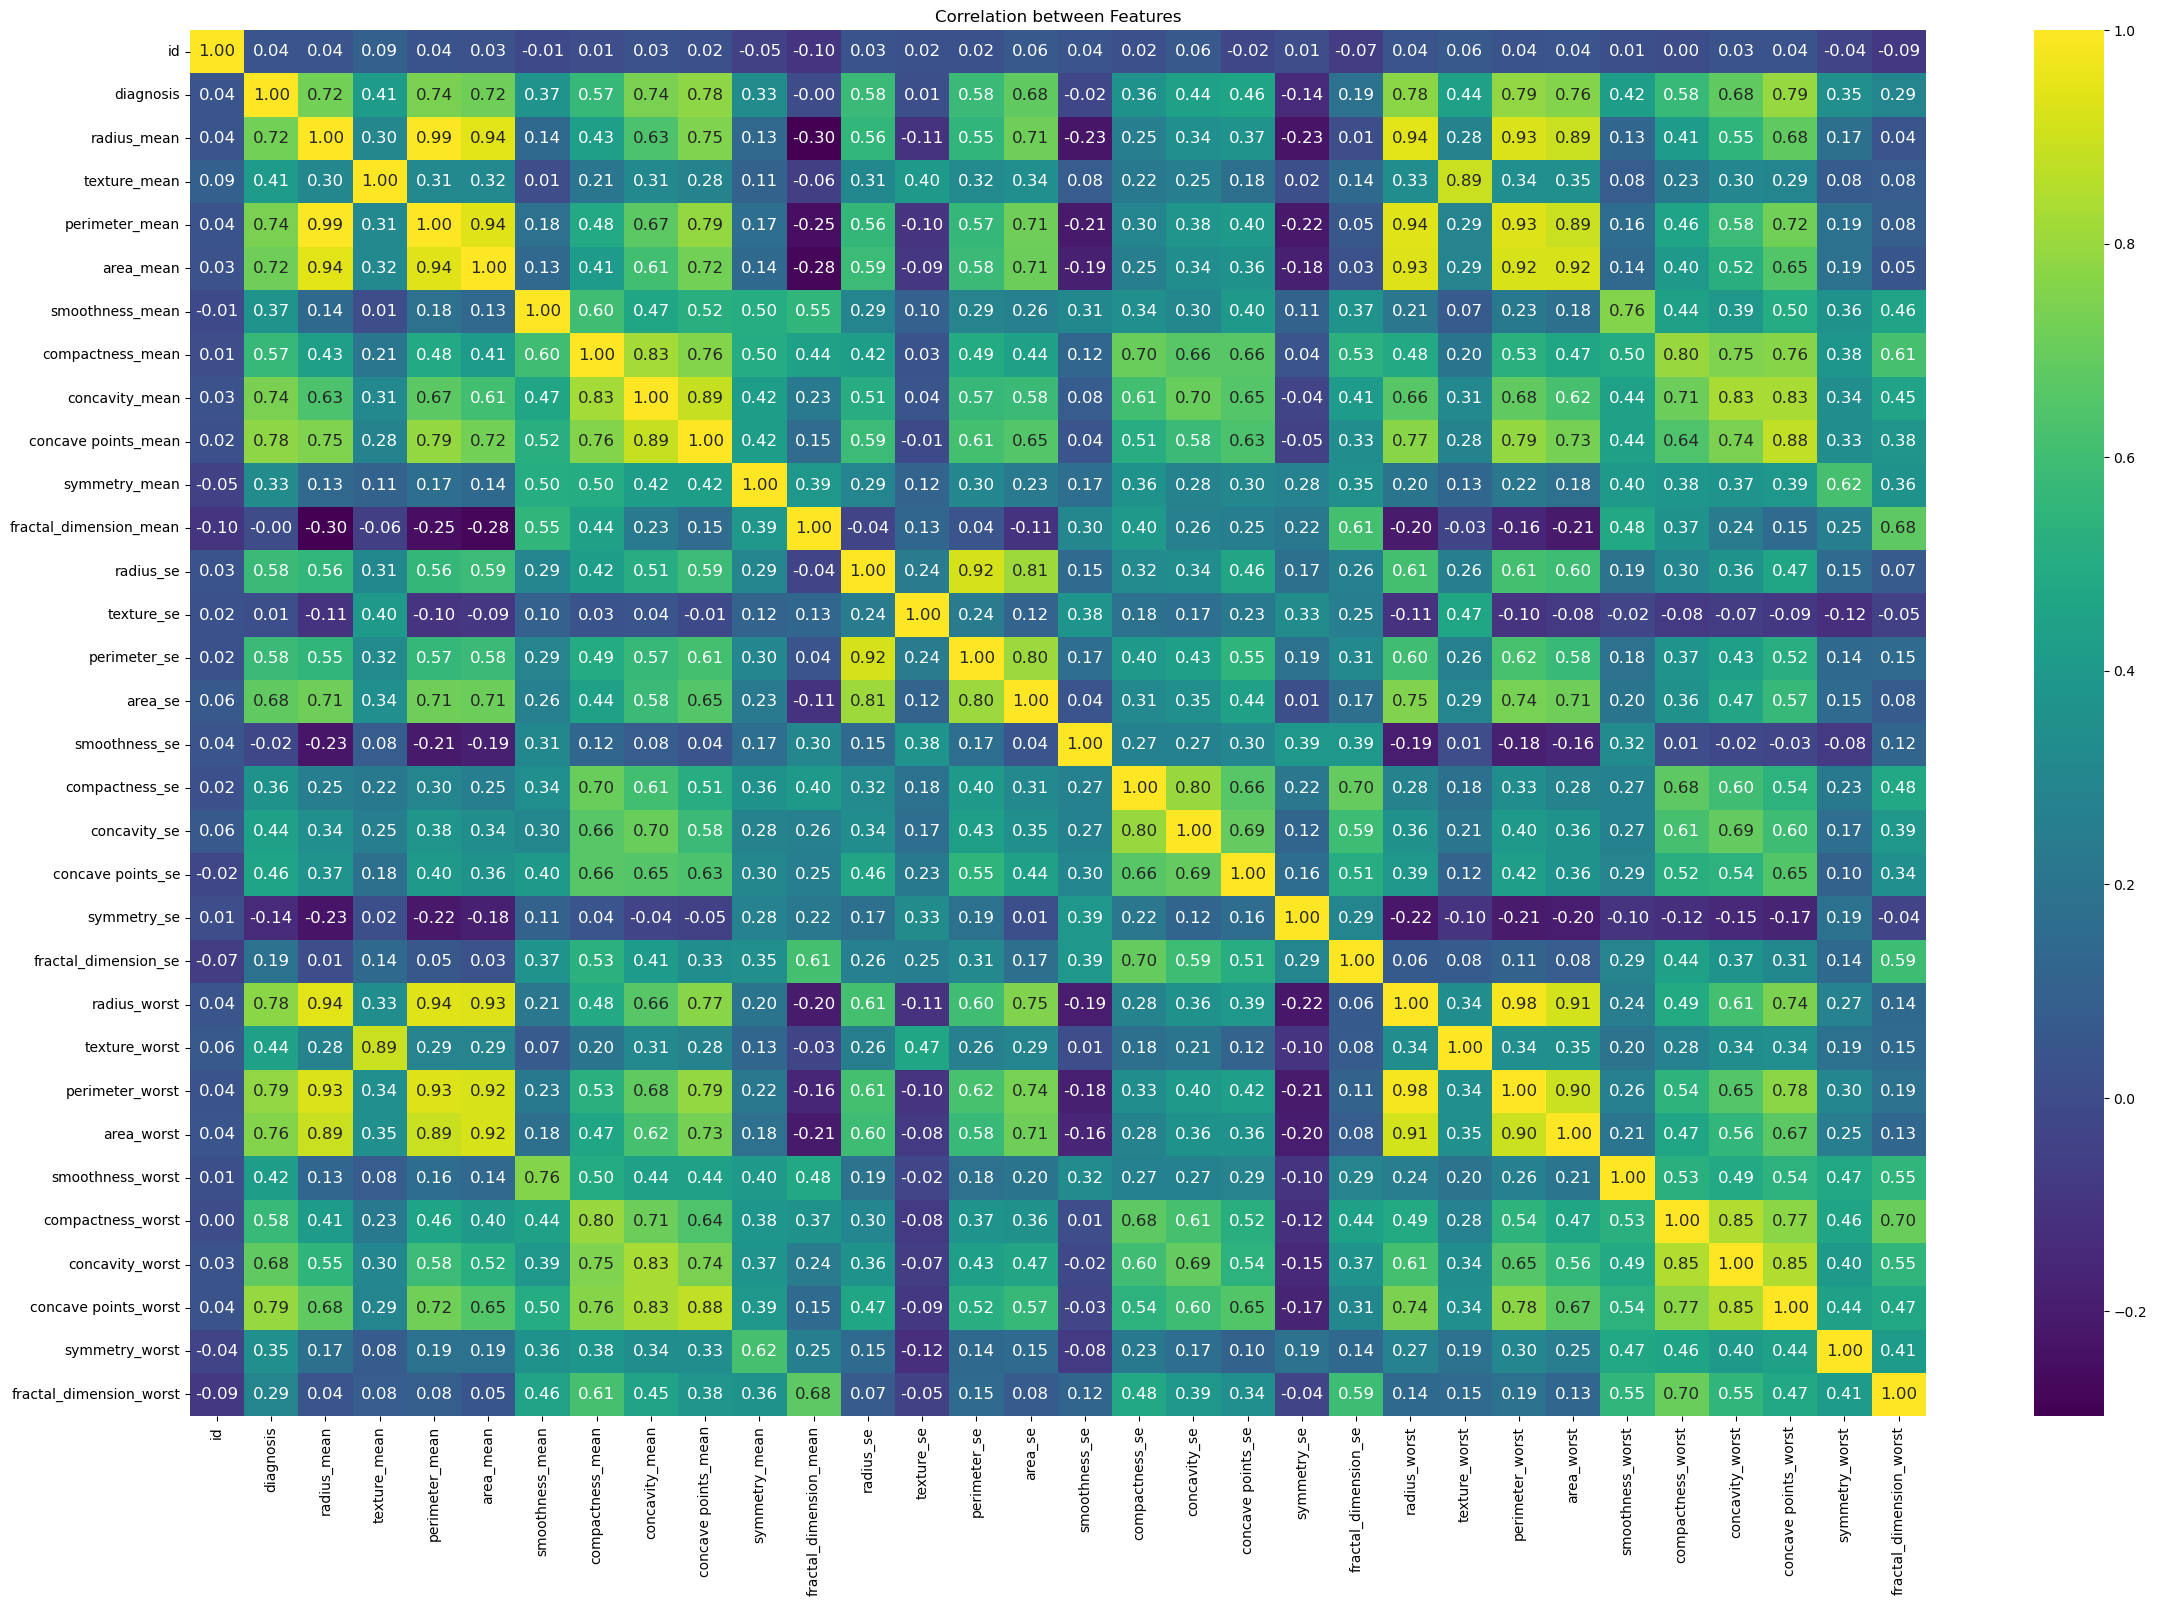

In [4]:
plt.figure(figsize=(28, 18))
sns.heatmap(df.corr(), annot=True, cmap='viridis', fmt=".2f", annot_kws={"size": 12})
plt.title('Correlation between Features')
plt.show()

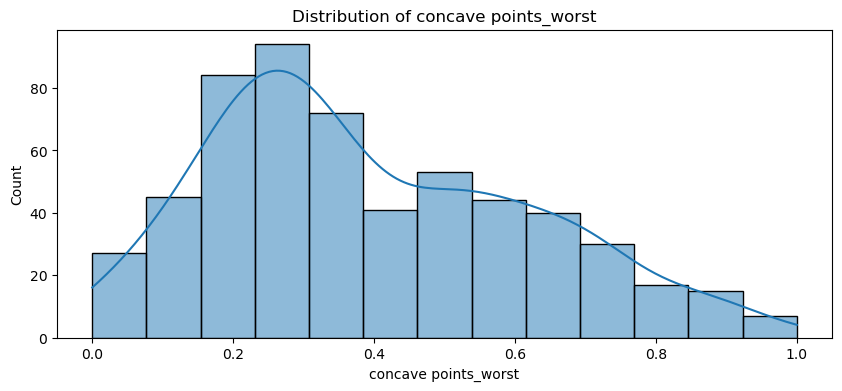

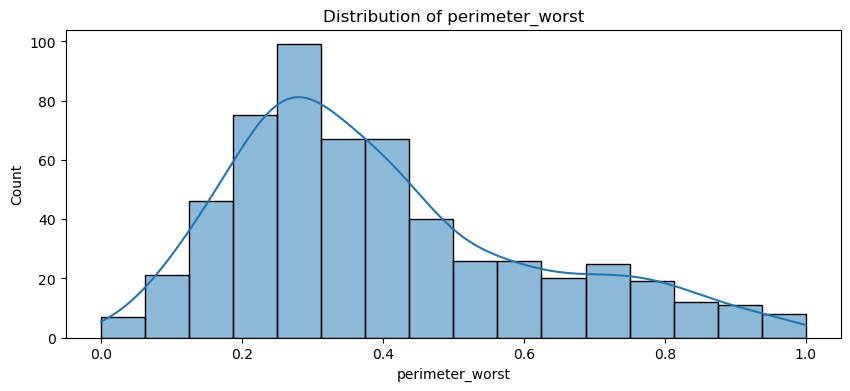

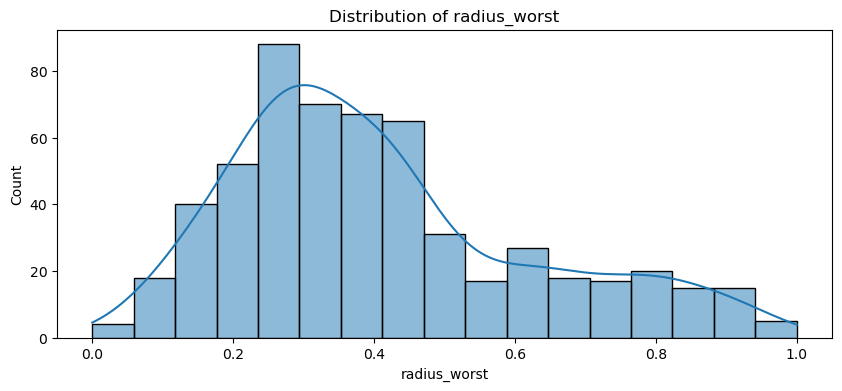

In [5]:
#The 3 most related values to our target feature "diagnosis" are "concave points_worst",
#"perimeter_worst", and "radius_worst" which have the following distributions:

features = ["concave points_worst", "perimeter_worst", "radius_worst"]
for feature in features:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

## 3. Data Splitting

Manually split the data into training and testing sets in a 70:30 ratio:
- Shuffle and split the data
- Avoid using predefined functions like train_test_split for this task


In [6]:
#Shuffling df with seed = 40 then splitting
shuffledDf = df.sample(frac=1, random_state=40).reset_index(drop=True)
    
splitIndex = int(0.7 * len(shuffledDf))
trainSet = shuffledDf.iloc[:splitIndex]
testSet = shuffledDf.iloc[splitIndex:]

## 4. Model Building

### 4.1. kNN Classifier

- Build and train the kNN model
- Choose the optimal k value using Minkowski distance with at least two different values for p 

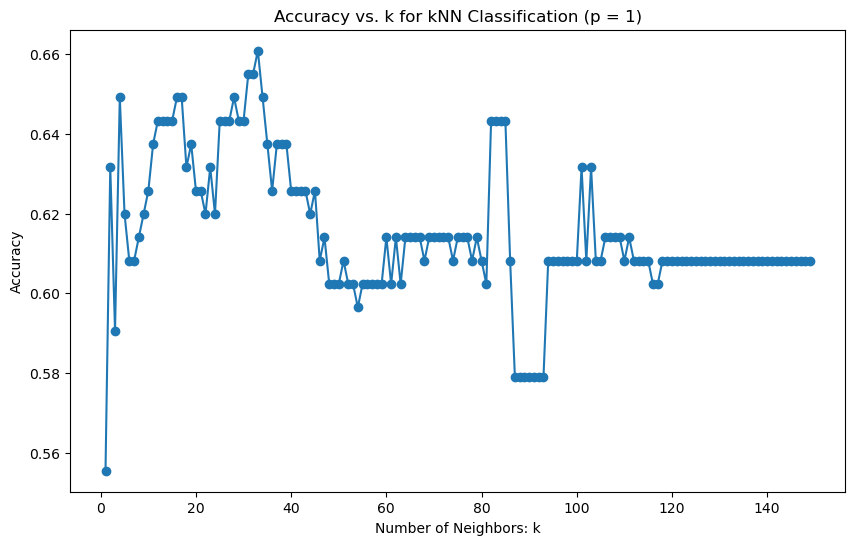

In [7]:
#A filter applied to ignore warning related to a change in SciPy library
simplefilter(action='ignore', category=FutureWarning)

#Split into target and feature sets
featureTrain = trainSet.drop('diagnosis', axis=1)
targetTrain = trainSet['diagnosis']

featureTest = testSet.drop('diagnosis', axis=1)
targetTest = testSet['diagnosis']

#Try values between 1 and 150 for k (after which accuracy doesn't change) with p = 1 and plot results
accuracyValues = []
kValues = range(1, 150)

for k in kValues:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1)

    knn.fit(featureTrain, targetTrain)

    yPred = knn.predict(featureTest)
    accuracy = accuracy_score(targetTest, yPred)
    accuracyValues.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(kValues, accuracyValues, marker='o')
plt.title('Accuracy vs. k for kNN Classification (p = 1)')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Accuracy')
plt.show()

#Obtain optimal k value, make a model with it and get its predictions and accuracy
manhattanOptimal_k = kValues[accuracyValues.index(max(accuracyValues))]
knnOptimal = KNeighborsClassifier(n_neighbors=manhattanOptimal_k)
knnOptimal.fit(featureTrain, targetTrain)
knn1_yPred = knnOptimal.predict(featureTest)
knn1Accuracy = accuracy_score(targetTest, knn1_yPred)

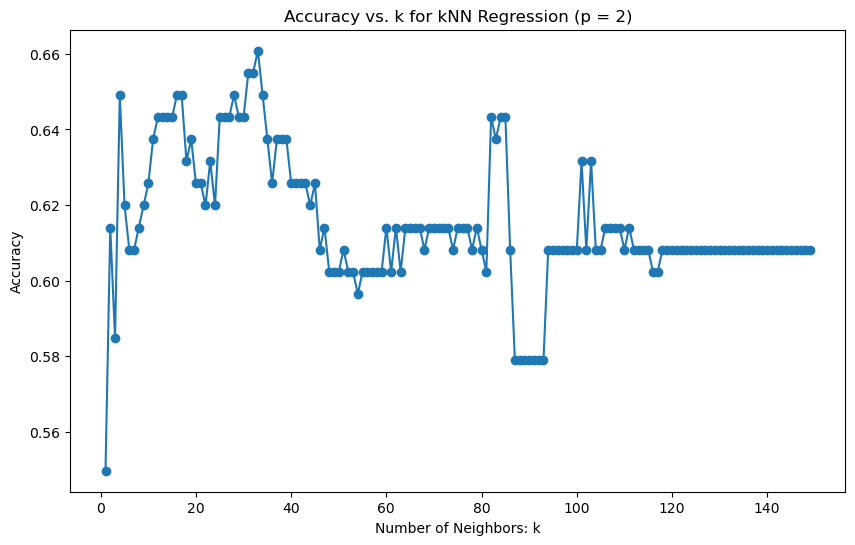

In [8]:
#We do the same for p = 2
accuracyValues = []
kValues = range(1, 150)

for k in kValues:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)

    knn.fit(featureTrain, targetTrain)

    yPred = knn.predict(featureTest)
    accuracy = accuracy_score(targetTest, yPred)
    accuracyValues.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(kValues, accuracyValues, marker='o')
plt.title('Accuracy vs. k for kNN Regression (p = 2)')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Accuracy')
plt.show()

euclideanOptimal_k = kValues[accuracyValues.index(max(accuracyValues))]
knnOptimal = KNeighborsClassifier(n_neighbors=euclideanOptimal_k)
knnOptimal.fit(featureTrain, targetTrain)
knn2_yPred = knnOptimal.predict(featureTest)
knn2Accuracy = accuracy_score(targetTest, knn2_yPred)

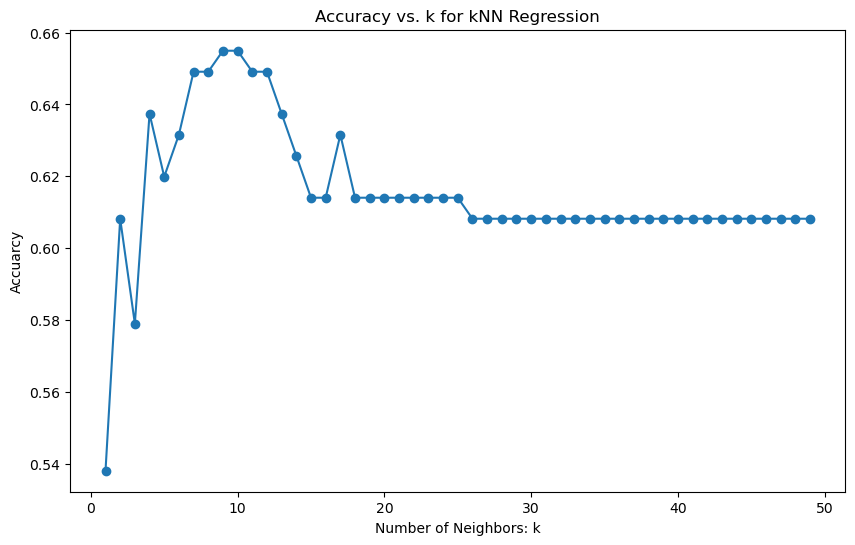

Optimal k for p=1:  33         Accuracy:  0.6608187134502924 
Optimal k for p=2:  33         Accuracy:  0.6608187134502924 
Optimal k for p=100:  9         Accuracy:  0.6198830409356725


In [9]:
#We try some absurd value like p = 100 to see if our results get better
accuracyValues = []
kValues = range(1, 50)

for k in kValues:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=100)

    knn.fit(featureTrain, targetTrain)

    yPred = knn.predict(featureTest)
    accuracy = accuracy_score(targetTest, yPred)
    accuracyValues.append(accuracy)


plt.figure(figsize=(10, 6))
plt.plot(kValues, accuracyValues, marker='o')
plt.title('Accuracy vs. k for kNN Regression')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Accuarcy')
plt.show()

highOptimal_k = kValues[accuracyValues.index(max(accuracyValues))]
knnOptimal = KNeighborsClassifier(n_neighbors=highOptimal_k)
knnOptimal.fit(featureTrain, targetTrain)
knn3_yPred = knnOptimal.predict(featureTest)
knn3Accuracy = accuracy_score(targetTest, knn3_yPred)

print("Optimal k for p=1: ", manhattanOptimal_k, "        Accuracy: ", knn1Accuracy,
      "\nOptimal k for p=2: ", euclideanOptimal_k, "        Accuracy: ", knn2Accuracy,
      "\nOptimal k for p=100: ", highOptimal_k, "        Accuracy: ", knn3Accuracy)

We can see that our results are kind of low for all p values, not exceeding the 67% mark, so we
can try to select the most effective features on diagnosis (we can find them out in the heatmap
drawn before).

In [10]:
#These are features that are correlated with our target feature by more than 0.50
selectedFeatures = ["radius_mean", "perimeter_mean", "area_mean", "concavity_mean", "concave points_mean", "area_se", "radius_se",
                 "perimeter_se", "radius_worst", "perimeter_worst", "area_worst", "concave points_worst", "compactness_mean",
                 "concavity_worst", "diagnosis"]

#Use the original shuffledDf to have the same dataset, and split only selected features into training and test sets
fliteredShuffledDf = shuffledDf[selectedFeatures]
    
split_index = int(0.7 * len(fliteredShuffledDf))
fliteredTrainSet = fliteredShuffledDf.iloc[:split_index]
filteredTestSet = fliteredShuffledDf.iloc[split_index:]

# "_" indicates usage of filtered/selected sets
featureTrain_ = fliteredTrainSet.drop('diagnosis', axis=1)
targetTrain_ = fliteredTrainSet['diagnosis']

featureTest_ = filteredTestSet.drop('diagnosis', axis=1)
targetTest_ = filteredTestSet['diagnosis']

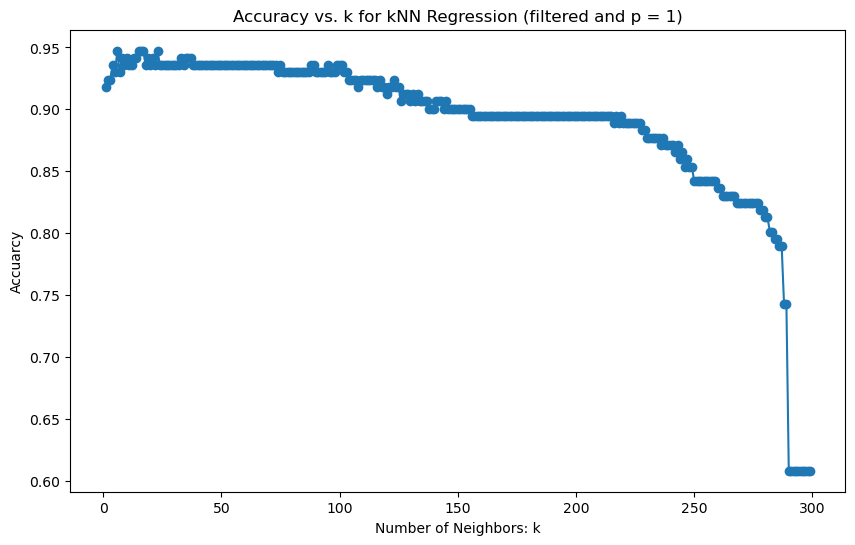

Optimal k for p = 1 with feature selection:  6         Accuracy:  0.935672514619883


In [11]:
#Same proccess as before except it is using selected features and p = 1
accuracyValues = []
kValues = range(1, 300)

for k in kValues:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1)

    knn.fit(featureTrain_, targetTrain_)

    yPred = knn.predict(featureTest_)
    accuracy = accuracy_score(targetTest_, yPred)
    accuracyValues.append(accuracy)


plt.figure(figsize=(10, 6))
plt.plot(kValues, accuracyValues, marker='o')
plt.title('Accuracy vs. k for kNN Regression (filtered and p = 1)')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Accuarcy')
plt.show()

filteredOptimal_k = kValues[accuracyValues.index(max(accuracyValues))]
knnOptimal = KNeighborsClassifier(n_neighbors=filteredOptimal_k)
knnOptimal.fit(featureTrain_, targetTrain_)
filteredKnn_yPred = knnOptimal.predict(featureTest_)
filteredKnnAccuracy = accuracy_score(targetTest_, filteredKnn_yPred)

print("Optimal k for p = 1 with feature selection: ", filteredOptimal_k,
      "        Accuracy: ", filteredKnnAccuracy,)

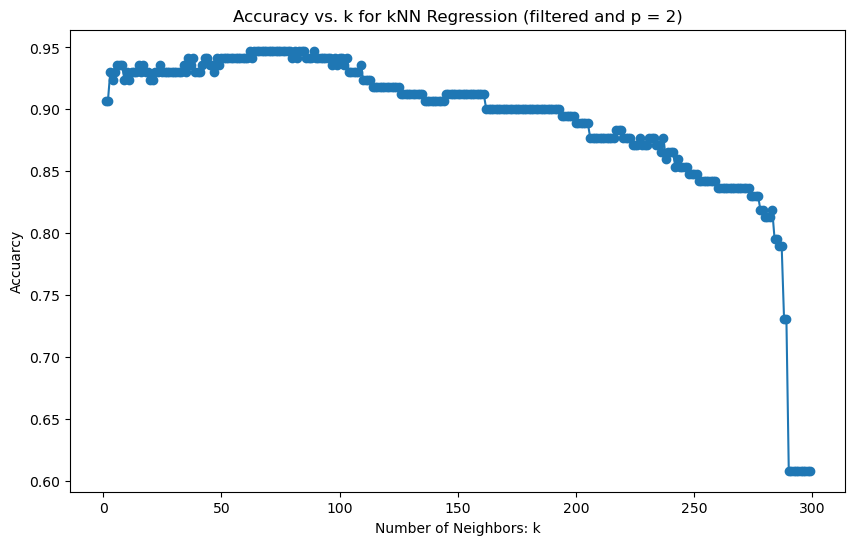

Optimal k for p = 2 with feature selection:  62         Accuracy:  0.9473684210526315


In [12]:
#p = 2
accuracyValues = []
kValues = range(1, 300)

for k in kValues:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)

    knn.fit(featureTrain_, targetTrain_)

    yPred = knn.predict(featureTest_)
    accuracy = accuracy_score(targetTest_, yPred)
    accuracyValues.append(accuracy)


plt.figure(figsize=(10, 6))
plt.plot(kValues, accuracyValues, marker='o')
plt.title('Accuracy vs. k for kNN Regression (filtered and p = 2)')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Accuarcy')
plt.show()

filteredOptimal_k = kValues[accuracyValues.index(max(accuracyValues))]
knnOptimal = KNeighborsClassifier(n_neighbors=filteredOptimal_k)
knnOptimal.fit(featureTrain_, targetTrain_)
filteredKnn_yPred = knnOptimal.predict(featureTest_)
filteredKnnAccuracy = accuracy_score(targetTest_, filteredKnn_yPred)

print("Optimal k for p = 2 with feature selection: ", filteredOptimal_k,
      "        Accuracy: ", filteredKnnAccuracy,)

We can see a much better result in accuracy when we use selected features, and while comparing p values p = 2 is better. so we are going to use this model as our knn model.

### 4.2. Logistic Regression

- Build and train the Logistic Regression model

In [13]:
model = LogisticRegression(max_iter=1000)

#Train the model on the original training data
model.fit(featureTrain, targetTrain)

yPred_prob = model.predict_proba(featureTest)[:, 1]

#Set the threshold
threshold = 0.5
log_yPred = (yPred_prob > threshold).astype(int)

print("Threshold = 0.5: \n", log_yPred)

threshold = 0.45
log_yPred = (yPred_prob > threshold).astype(int)

print("\nThreshold = 0.45: \n", log_yPred)

Threshold = 0.5: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Threshold = 0.45: 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


As we can see, our model is guessing all values between in a range of small thresholds, when we try to change threshold we can see that all predictions lie between 0.45 and 0.5, which can be bad for our case.. so we can try to use selected features just like we did in the knn model to get better results

In [14]:
model = LogisticRegression(max_iter=1500)

#Train the model on the selected features training data
model.fit(featureTrain_, targetTrain_)

yPred_prob = model.predict_proba(featureTest_)[:, 1]

# Adjust the threshold
threshold = 0.5
log_yPred = (yPred_prob > threshold).astype(int)

print(log_yPred)

[1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0
 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0
 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1
 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0]


Predictions became more balanced, and evaluation will be seen in the next part

## 5. Model Evaluation

### 5.1. Confusion Matrix

Analysis of the confusion matrices for both models:
- Plot and interpret the confusion matrices
- Display accuracy, precision, recall, and F1-score for both models

In [18]:
log_conf_matrix = confusion_matrix(targetTest, log_yPred)
knn_conf_matrix = confusion_matrix(targetTest, filteredKnn_yPred)

print('KNN Confusion Matrix:')
print(knn_conf_matrix)

print('\nLogistic Regression Confusion Matrix:')
print(log_conf_matrix)

KNN Confusion Matrix:
[[104   0]
 [  9  58]]

Logistic Regression Confusion Matrix:
[[101   3]
 [  7  60]]


KNN confusion matrix:
We can see that all its 104 positive predictions were true with no FPs, and while 58 negative predictions were true 9 were false negatives (FN)


Logistic Regression Confusion Matrix:
Although it has similar results to knn, its positive predictions weren't always true with a ratio of 101:3 TP:FP. but it had less false negatives than the KNN model with 60 true negatives and 7 false negatives.

In [19]:
print("\nKNN Model Metrics:")
print("Accuracy:", accuracy_score(targetTest, filteredKnn_yPred))
print("Precision:", precision_score(targetTest, filteredKnn_yPred))
print("Recall:", recall_score(targetTest, filteredKnn_yPred))
print("F1 Score:", f1_score(targetTest, filteredKnn_yPred))

print("\nLogistic Regression Model Metrics:")
print("Accuracy:", accuracy_score(targetTest, log_yPred))
print("Precision:", precision_score(targetTest, log_yPred))
print("Recall:", recall_score(targetTest, log_yPred))
print("F1 Score:", f1_score(targetTest, log_yPred))


KNN Model Metrics:
Accuracy: 0.9473684210526315
Precision: 1.0
Recall: 0.8656716417910447
F1 Score: 0.928

Logistic Regression Model Metrics:
Accuracy: 0.9415204678362573
Precision: 0.9523809523809523
Recall: 0.8955223880597015
F1 Score: 0.923076923076923


### 5.2. Precision-Recall Curves

Evaluate the Precision-Recall curves for both models:
- Plot and analyze the curves

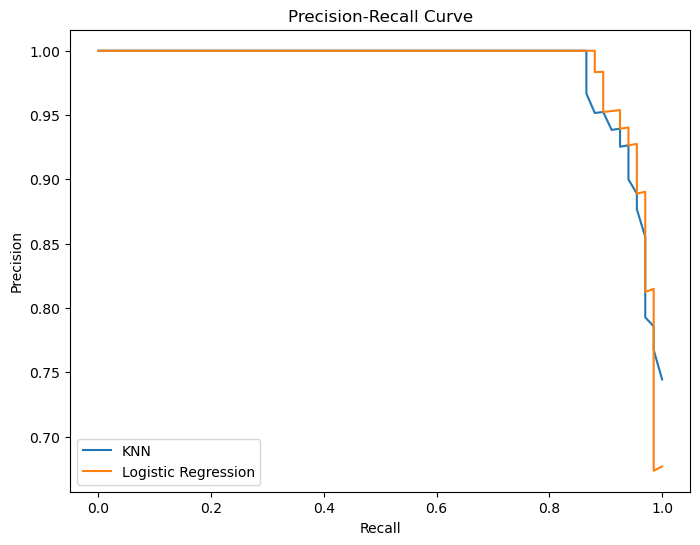

In [16]:
knn_probs = knnOptimal.predict_proba(featureTest_)[:, 1]
log_probs = model.predict_proba(featureTest_)[:, 1]

#Calculate precision-recall curve values
knn_precision, knn_recall, _ = precision_recall_curve(targetTest, knn_probs)
log_precision, log_recall, _ = precision_recall_curve(targetTest_, log_probs)

#Plot Precision-Recall curves
plt.figure(figsize=(8, 6))
plt.plot(knn_recall, knn_precision, label='KNN')
plt.plot(log_recall, log_precision, label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

We know that the closer the curve is to the upper right point of the graph (Precision = Recall = 1) and the bigger the area under our curve is the better our model. in this case we can see logistic regression having a bigger AUC and is closer to (1,1) so we can say using PR curve logistic regression is better than our KNN model by a small margin.

### 5.3. Choose an appropriate metric to evaulate the models. Compare the models and discuss why you chose the metric.

In [17]:
class_counts = df['diagnosis'].value_counts()
class_counts

0    357
1    212
Name: diagnosis, dtype: int64

Although both models had scores really close to each other in most metrics, if I had to choose a metric for our case I would choose the F1-score for multiple reasons. First, unlike accuracy, the F1-score is good for imbalanced class datasets, and in our dataset, one class has nearly 75% more elements than the other. Second, it is a good balance between precision and recall. Finally, in addition to that its an easily comparable metric, in our situation of medical tumors detection, false-positives and false-negatives can be important to detect. Something that the F1-score is good at.

If we retreive our previous results, we would see that:

KNN F1 Score: 0.928, 
Logistic Regrission F1 Score: 0.923076923076923

We see that although by a pretty small margin (~0.5%), KNN's F1-score is better than logistic regression model's is